# General models

Aim to create a range of underfitting, overfitting and fairly well optimised models based on bitcoin dataset.

These models will help give some indication of the effects of adding and removing parameters and hyperparameters and serve as a set of baseline models to work from when optimising each coin for the most effective sets of parameters found.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
bitcoin_csv = os.path.join(current_folder, "data","bitcoin_hourly.csv")
bitcoin_df = pd.read_csv(bitcoin_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
bitcoin_df['highLowDif'] = bitcoin_df['highPriceUsd'] - bitcoin_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = bitcoin_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = bitcoin_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = bitcoin_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [2]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [3]:
bitcoin_df.iloc[0]

datetime                      2021-02-03 00:00:00+00:00
bitcoin_count                                      1557
bitcoin_polarity                               0.198884
bitcoin_subjectivity                           0.503805
bitcoin_polarity_zeros                         0.105064
bitcoin_subjectivity_zeros                     0.303084
openPriceUsd                                    35510.8
closePriceUsd                                   36119.5
highPriceUsd                                    36131.9
lowPriceUsd                                       35444
volume                                      62260118369
marketcap                                  672459334169
highLowDif                                      687.926
Name: 0, dtype: object

In [4]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'bitcoin_polarity', 'bitcoin_subjectivity', 'openPriceUsd',  'marketcap', 'highLowDif'])

In [5]:
timeperiod_df.iloc[0]

bitcoin_count                 1.557000e+03
bitcoin_polarity_zeros        1.050641e-01
bitcoin_subjectivity_zeros    3.030843e-01
closePriceUsd                 3.611949e+04
highPriceUsd                  3.613191e+04
lowPriceUsd                   3.544398e+04
volume                        6.226012e+10
Name: 0, dtype: float64

In [6]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples, validation_samples)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples, validation_samples)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 1680th, validation: 2160th, test: 2400th
Input shape: (128, 120, 7)
Target shape: (128, 1)


In [7]:
# extracting targets from the val_dataset to plot alongside predictions
y_val = np.concatenate([y for x, y in val_dataset], axis=0)

In [8]:
# This doesn't create a full dataset between the points
# find better method if time (like below)
combined_dataset = train_dataset.concatenate(val_dataset)

In [9]:
# setting up customised test_dataset
test_data = timeperiod_df[(training_samples+validation_samples) - lookback + delay:len(timeperiod_df) - delay - 1].to_numpy()

test_targets = timeperiod_df.iloc[(training_samples+validation_samples)+ delay + delay:, timeperiod_df.columns.get_loc("closePriceUsd")]
test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        test_data,
        None,
        sequence_length=lookback,
        sampling_rate=step,
        batch_size=batch_size,
    )

## LSTM models

Epoch 1/20
13/13 [==============================] - 12s 627ms/step - loss: 0.4390 - val_loss: 0.4587
Epoch 2/20
13/13 [==============================] - 7s 511ms/step - loss: 0.2031 - val_loss: 0.4787
Epoch 3/20
13/13 [==============================] - 7s 537ms/step - loss: 0.1721 - val_loss: 0.4447
Epoch 4/20
13/13 [==============================] - 6s 485ms/step - loss: 0.1695 - val_loss: 0.4066
Epoch 5/20
13/13 [==============================] - 6s 465ms/step - loss: 0.1646 - val_loss: 0.3707
Epoch 6/20
13/13 [==============================] - 6s 490ms/step - loss: 0.1597 - val_loss: 0.3416
Epoch 7/20
13/13 [==============================] - 7s 532ms/step - loss: 0.1543 - val_loss: 0.3364
Epoch 8/20
13/13 [==============================] - 7s 522ms/step - loss: 0.1492 - val_loss: 0.2685
Epoch 9/20
13/13 [==============================] - 6s 465ms/step - loss: 0.1396 - val_loss: 0.2111
Epoch 10/20
13/13 [==============================] - 6s 467ms/step - loss: 0.1256 - val_loss: 0.169

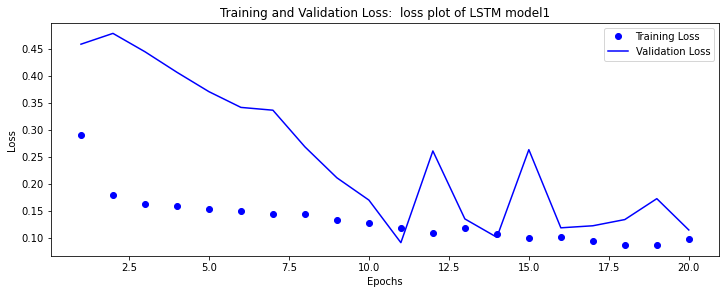

In [10]:
LSTM_model1 = models.Sequential()
LSTM_model1.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model1.add(layers.LSTM(100))


LSTM_model1.add(layers.Dense(1))

LSTM_model1.compile(optimizer=RMSprop(), loss='mse')
LSTM_model1_history = LSTM_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model1_history, "loss plot of LSTM model1")

Epoch 1/20
13/13 [==============================] - 10s 558ms/step - loss: 0.4014 - val_loss: 0.6378
Epoch 2/20
13/13 [==============================] - 8s 601ms/step - loss: 0.2225 - val_loss: 0.5351
Epoch 3/20
13/13 [==============================] - 8s 592ms/step - loss: 0.1668 - val_loss: 0.5028
Epoch 4/20
13/13 [==============================] - 8s 635ms/step - loss: 0.1629 - val_loss: 0.4748
Epoch 5/20
13/13 [==============================] - 9s 679ms/step - loss: 0.1582 - val_loss: 0.4539
Epoch 6/20
13/13 [==============================] - 7s 537ms/step - loss: 0.1584 - val_loss: 0.4277
Epoch 7/20
13/13 [==============================] - 7s 585ms/step - loss: 0.1459 - val_loss: 0.3086
Epoch 8/20
13/13 [==============================] - 8s 634ms/step - loss: 0.1330 - val_loss: 0.3107
Epoch 9/20
13/13 [==============================] - 7s 525ms/step - loss: 0.1322 - val_loss: 0.2390
Epoch 10/20
13/13 [==============================] - 7s 561ms/step - loss: 0.1256 - val_loss: 0.186

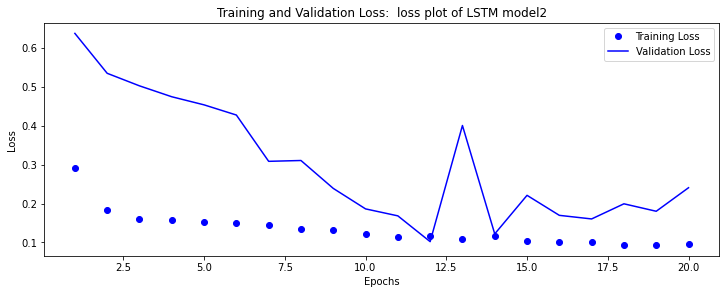

In [11]:
LSTM_model2 = models.Sequential()
LSTM_model2.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model2.add(layers.LSTM(100))


LSTM_model2.add(layers.Dense(1))

LSTM_model2.compile(optimizer=RMSprop(), loss='mse')
LSTM_model2_history = LSTM_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model2_history, "loss plot of LSTM model2")

Epoch 1/20
13/13 [==============================] - 9s 501ms/step - loss: 0.3846 - val_loss: 0.4638
Epoch 2/20
13/13 [==============================] - 5s 392ms/step - loss: 0.2076 - val_loss: 0.3596
Epoch 3/20
13/13 [==============================] - 6s 389ms/step - loss: 0.1740 - val_loss: 0.3405
Epoch 4/20
13/13 [==============================] - 6s 500ms/step - loss: 0.1683 - val_loss: 0.3220
Epoch 5/20
13/13 [==============================] - 5s 361ms/step - loss: 0.1617 - val_loss: 0.3090
Epoch 6/20
13/13 [==============================] - 5s 401ms/step - loss: 0.1553 - val_loss: 0.3011
Epoch 7/20
13/13 [==============================] - 6s 478ms/step - loss: 0.1481 - val_loss: 0.2862
Epoch 8/20
13/13 [==============================] - 6s 445ms/step - loss: 0.1381 - val_loss: 0.2779
Epoch 9/20
13/13 [==============================] - 6s 481ms/step - loss: 0.1326 - val_loss: 0.1431
Epoch 10/20
13/13 [==============================] - 6s 499ms/step - loss: 0.1215 - val_loss: 0.2009

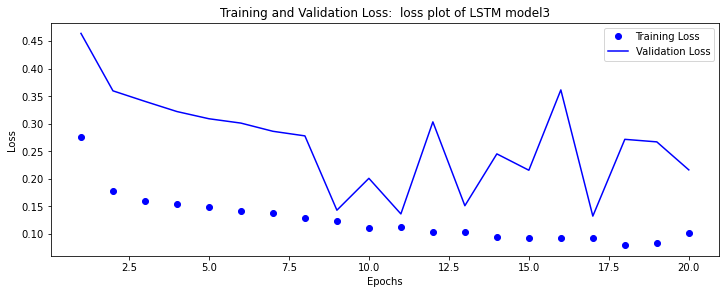

In [12]:
LSTM_model3 = models.Sequential()
LSTM_model3.add(layers.LSTM(100, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model3.add(layers.LSTM(50))


LSTM_model3.add(layers.Dense(1))

LSTM_model3.compile(optimizer=RMSprop(), loss='mse')
LSTM_model3_history = LSTM_model3.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model3_history, "loss plot of LSTM model3")

Epoch 1/20
13/13 [==============================] - 13s 559ms/step - loss: 0.3860 - val_loss: 0.5845
Epoch 2/20
13/13 [==============================] - 5s 427ms/step - loss: 0.2043 - val_loss: 0.4520
Epoch 3/20
13/13 [==============================] - 6s 502ms/step - loss: 0.1745 - val_loss: 0.4194
Epoch 4/20
13/13 [==============================] - 6s 467ms/step - loss: 0.1720 - val_loss: 0.3440
Epoch 5/20
13/13 [==============================] - 6s 488ms/step - loss: 0.1622 - val_loss: 0.3167
Epoch 6/20
13/13 [==============================] - 7s 559ms/step - loss: 0.1563 - val_loss: 0.2926
Epoch 7/20
13/13 [==============================] - 6s 488ms/step - loss: 0.1512 - val_loss: 0.2566
Epoch 8/20
13/13 [==============================] - 6s 460ms/step - loss: 0.1488 - val_loss: 0.2515
Epoch 9/20
13/13 [==============================] - 6s 423ms/step - loss: 0.1442 - val_loss: 0.2272
Epoch 10/20
13/13 [==============================] - 6s 500ms/step - loss: 0.1403 - val_loss: 0.224

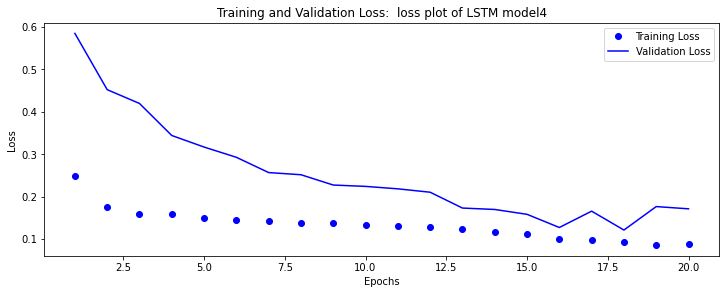

In [13]:
LSTM_model4 = models.Sequential()
LSTM_model4.add(layers.LSTM(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model4.add(layers.LSTM(50))


LSTM_model4.add(layers.Dense(1))

LSTM_model4.compile(optimizer=RMSprop(), loss='mse')
LSTM_model4_history = LSTM_model4.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model4_history, "loss plot of LSTM model4")

Epoch 1/30
13/13 [==============================] - 11s 482ms/step - loss: 0.4862 - val_loss: 0.4632
Epoch 2/30
13/13 [==============================] - 6s 379ms/step - loss: 0.1899 - val_loss: 0.3703
Epoch 3/30
13/13 [==============================] - 5s 367ms/step - loss: 0.1765 - val_loss: 0.3268
Epoch 4/30
13/13 [==============================] - 5s 363ms/step - loss: 0.1684 - val_loss: 0.2974
Epoch 5/30
13/13 [==============================] - 5s 387ms/step - loss: 0.1616 - val_loss: 0.2763
Epoch 6/30
13/13 [==============================] - 5s 416ms/step - loss: 0.1556 - val_loss: 0.2593
Epoch 7/30
13/13 [==============================] - 5s 363ms/step - loss: 0.1502 - val_loss: 0.2450
Epoch 8/30
13/13 [==============================] - 5s 387ms/step - loss: 0.1452 - val_loss: 0.2332
Epoch 9/30
13/13 [==============================] - 5s 363ms/step - loss: 0.1401 - val_loss: 0.2249
Epoch 10/30
13/13 [==============================] - 6s 471ms/step - loss: 0.1345 - val_loss: 0.215

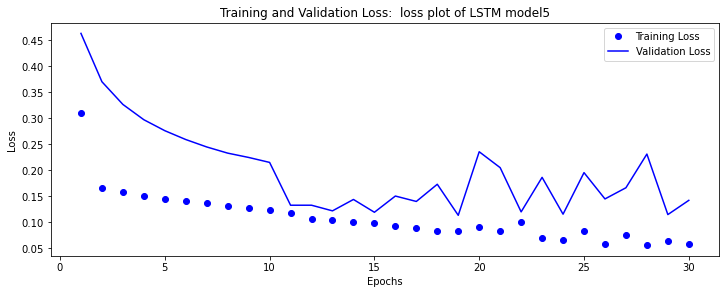

In [14]:
LSTM_model5 = models.Sequential()
LSTM_model5.add(layers.LSTM(50, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model5.add(layers.LSTM(50))


LSTM_model5.add(layers.Dense(1))

LSTM_model5.compile(optimizer=RMSprop(), loss='mse')
LSTM_model5_history = LSTM_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model5_history, "loss plot of LSTM model5")

Epoch 1/20
13/13 [==============================] - 15s 657ms/step - loss: 0.3423 - val_loss: 0.4162
Epoch 2/20
13/13 [==============================] - 7s 526ms/step - loss: 0.1781 - val_loss: 0.3296
Epoch 3/20
13/13 [==============================] - 6s 446ms/step - loss: 0.1665 - val_loss: 0.2879
Epoch 4/20
13/13 [==============================] - 5s 402ms/step - loss: 0.1590 - val_loss: 0.2559
Epoch 5/20
13/13 [==============================] - 5s 360ms/step - loss: 0.1550 - val_loss: 0.2283
Epoch 6/20
13/13 [==============================] - 5s 354ms/step - loss: 0.1451 - val_loss: 0.2138
Epoch 7/20
13/13 [==============================] - 5s 357ms/step - loss: 0.1440 - val_loss: 0.2026
Epoch 8/20
13/13 [==============================] - 5s 353ms/step - loss: 0.1395 - val_loss: 0.2000
Epoch 9/20
13/13 [==============================] - 4s 343ms/step - loss: 0.1364 - val_loss: 0.1839
Epoch 10/20
13/13 [==============================] - 4s 346ms/step - loss: 0.1356 - val_loss: 0.180

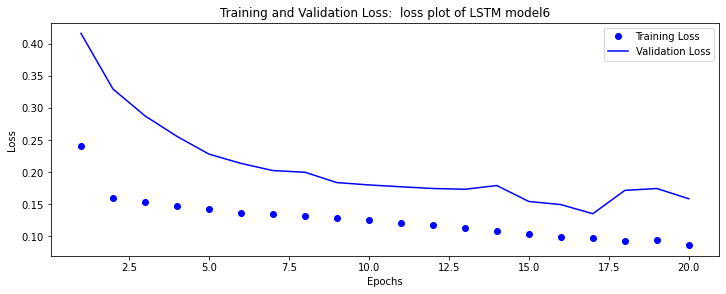

In [15]:
LSTM_model6 = models.Sequential()
LSTM_model6.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model6.add(layers.LSTM(50))


LSTM_model6.add(layers.Dense(1))

LSTM_model6.compile(optimizer=RMSprop(), loss='mse')
LSTM_model6_history = LSTM_model6.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model6_history, "loss plot of LSTM model6")

Epoch 1/30
13/13 [==============================] - 9s 339ms/step - loss: 0.3238 - val_loss: 0.3997
Epoch 2/30
13/13 [==============================] - 4s 296ms/step - loss: 0.1717 - val_loss: 0.3068
Epoch 3/30
13/13 [==============================] - 4s 293ms/step - loss: 0.1593 - val_loss: 0.2741
Epoch 4/30
13/13 [==============================] - 4s 277ms/step - loss: 0.1538 - val_loss: 0.2537
Epoch 5/30
13/13 [==============================] - 3s 263ms/step - loss: 0.1495 - val_loss: 0.2388
Epoch 6/30
13/13 [==============================] - 3s 256ms/step - loss: 0.1459 - val_loss: 0.2271
Epoch 7/30
13/13 [==============================] - 3s 258ms/step - loss: 0.1427 - val_loss: 0.2175
Epoch 8/30
13/13 [==============================] - 3s 254ms/step - loss: 0.1399 - val_loss: 0.2094
Epoch 9/30
13/13 [==============================] - 3s 265ms/step - loss: 0.1373 - val_loss: 0.2024
Epoch 10/30
13/13 [==============================] - 3s 264ms/step - loss: 0.1349 - val_loss: 0.1963

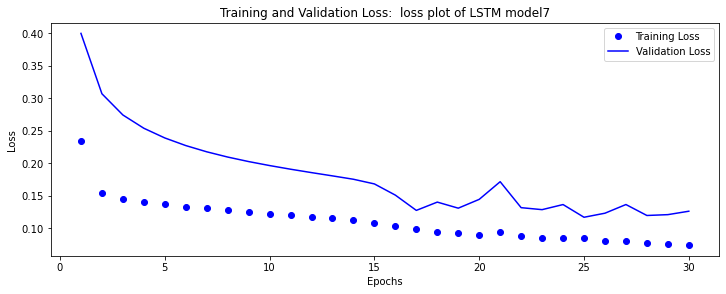

In [16]:
LSTM_model7 = models.Sequential()
LSTM_model7.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model7.add(layers.LSTM(32))


LSTM_model7.add(layers.Dense(1))

LSTM_model7.compile(optimizer=RMSprop(), loss='mse')
LSTM_model7_history = LSTM_model7.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model7_history, "loss plot of LSTM model7")

Epoch 1/20
13/13 [==============================] - 9s 349ms/step - loss: 0.3494 - val_loss: 0.4233
Epoch 2/20
13/13 [==============================] - 4s 290ms/step - loss: 0.1769 - val_loss: 0.3364
Epoch 3/20
13/13 [==============================] - 4s 290ms/step - loss: 0.1732 - val_loss: 0.2967
Epoch 4/20
13/13 [==============================] - 4s 286ms/step - loss: 0.1620 - val_loss: 0.2609
Epoch 5/20
13/13 [==============================] - 4s 278ms/step - loss: 0.1594 - val_loss: 0.2400
Epoch 6/20
13/13 [==============================] - 4s 290ms/step - loss: 0.1520 - val_loss: 0.2173
Epoch 7/20
13/13 [==============================] - 4s 288ms/step - loss: 0.1511 - val_loss: 0.2073
Epoch 8/20
13/13 [==============================] - 4s 284ms/step - loss: 0.1477 - val_loss: 0.1897
Epoch 9/20
13/13 [==============================] - 4s 291ms/step - loss: 0.1434 - val_loss: 0.1784
Epoch 10/20
13/13 [==============================] - 4s 321ms/step - loss: 0.1407 - val_loss: 0.1671

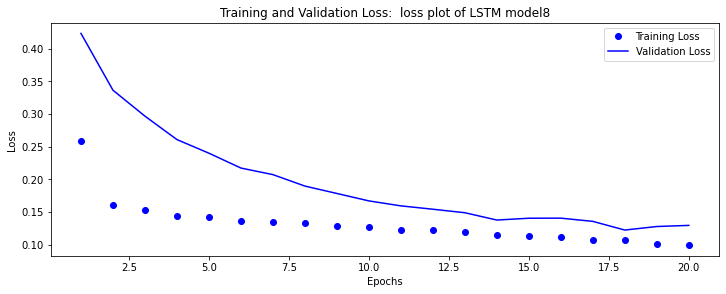

In [17]:
LSTM_model8 = models.Sequential()
LSTM_model8.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model8.add(layers.LSTM(32))


LSTM_model8.add(layers.Dense(1))

LSTM_model8.compile(optimizer=RMSprop(), loss='mse')
LSTM_model8_history = LSTM_model8.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model8_history, "loss plot of LSTM model8")

Epoch 1/30
13/13 [==============================] - 10s 363ms/step - loss: 0.3847 - val_loss: 0.1707
Epoch 2/30
13/13 [==============================] - 4s 305ms/step - loss: 0.1517 - val_loss: 0.2366
Epoch 3/30
13/13 [==============================] - 4s 306ms/step - loss: 0.1566 - val_loss: 0.2332
Epoch 4/30
13/13 [==============================] - 3s 253ms/step - loss: 0.1529 - val_loss: 0.2217
Epoch 5/30
13/13 [==============================] - 4s 302ms/step - loss: 0.1479 - val_loss: 0.2104
Epoch 6/30
13/13 [==============================] - 4s 321ms/step - loss: 0.1431 - val_loss: 0.2002
Epoch 7/30
13/13 [==============================] - 5s 379ms/step - loss: 0.1387 - val_loss: 0.1912
Epoch 8/30
13/13 [==============================] - 3s 245ms/step - loss: 0.1347 - val_loss: 0.1831
Epoch 9/30
13/13 [==============================] - 3s 251ms/step - loss: 0.1311 - val_loss: 0.1758
Epoch 10/30
13/13 [==============================] - 3s 250ms/step - loss: 0.1279 - val_loss: 0.169

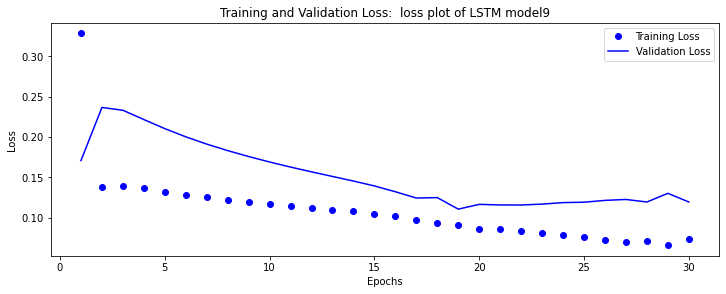

In [18]:
LSTM_model9 = models.Sequential()
LSTM_model9.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model9.add(layers.LSTM(16))


LSTM_model9.add(layers.Dense(1))

LSTM_model9.compile(optimizer=RMSprop(), loss='mse')
LSTM_model9_history = LSTM_model9.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model9_history, "loss plot of LSTM model9")

Epoch 1/20
13/13 [==============================] - 7s 277ms/step - loss: 0.5915 - val_loss: 0.1730
Epoch 2/20
13/13 [==============================] - 4s 282ms/step - loss: 0.1988 - val_loss: 0.2499
Epoch 3/20
13/13 [==============================] - 3s 230ms/step - loss: 0.1763 - val_loss: 0.2516
Epoch 4/20
13/13 [==============================] - 3s 255ms/step - loss: 0.1664 - val_loss: 0.2439
Epoch 5/20
13/13 [==============================] - 3s 223ms/step - loss: 0.1590 - val_loss: 0.2330
Epoch 6/20
13/13 [==============================] - 4s 343ms/step - loss: 0.1524 - val_loss: 0.2225
Epoch 7/20
13/13 [==============================] - 3s 222ms/step - loss: 0.1512 - val_loss: 0.2123
Epoch 8/20
13/13 [==============================] - 4s 298ms/step - loss: 0.1450 - val_loss: 0.2066
Epoch 9/20
13/13 [==============================] - 3s 241ms/step - loss: 0.1383 - val_loss: 0.1992
Epoch 10/20
13/13 [==============================] - 3s 228ms/step - loss: 0.1380 - val_loss: 0.1923

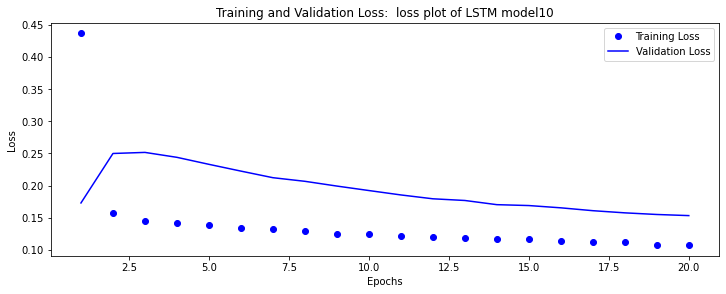

In [19]:
LSTM_model10 = models.Sequential()
LSTM_model10.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model10.add(layers.LSTM(16))


LSTM_model10.add(layers.Dense(1))

LSTM_model10.compile(optimizer=RMSprop(), loss='mse')
LSTM_model10_history = LSTM_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model10_history, "loss plot of LSTM model10")

Epoch 1/50
13/13 [==============================] - 6s 261ms/step - loss: 0.4691 - val_loss: 0.1498
Epoch 2/50
13/13 [==============================] - 3s 214ms/step - loss: 0.3353 - val_loss: 0.1244
Epoch 3/50
13/13 [==============================] - 3s 217ms/step - loss: 0.2736 - val_loss: 0.1137
Epoch 4/50
13/13 [==============================] - 3s 219ms/step - loss: 0.2302 - val_loss: 0.1155
Epoch 5/50
13/13 [==============================] - 3s 214ms/step - loss: 0.1966 - val_loss: 0.1293
Epoch 6/50
13/13 [==============================] - 3s 218ms/step - loss: 0.1810 - val_loss: 0.1516
Epoch 7/50
13/13 [==============================] - 3s 214ms/step - loss: 0.1646 - val_loss: 0.1760
Epoch 8/50
13/13 [==============================] - 3s 225ms/step - loss: 0.1610 - val_loss: 0.1954
Epoch 9/50
13/13 [==============================] - 3s 226ms/step - loss: 0.1563 - val_loss: 0.2077
Epoch 10/50
13/13 [==============================] - 3s 262ms/step - loss: 0.1557 - val_loss: 0.2152

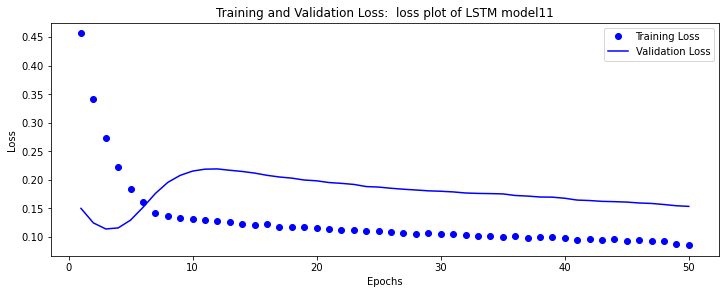

In [20]:
LSTM_model11 = models.Sequential()
LSTM_model11.add(layers.LSTM(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

LSTM_model11.add(layers.LSTM(5))


LSTM_model11.add(layers.Dense(1))

LSTM_model11.compile(optimizer=RMSprop(), loss='mse')
LSTM_model11_history = LSTM_model11.fit(train_dataset, epochs=50, validation_data=val_dataset)

plot_simple_loss(LSTM_model11_history, "loss plot of LSTM model11")

Epoch 1/20
13/13 [==============================] - 16s 781ms/step - loss: 0.3539 - val_loss: 1.0190
Epoch 2/20
13/13 [==============================] - 8s 618ms/step - loss: 0.2380 - val_loss: 0.7360
Epoch 3/20
13/13 [==============================] - 7s 516ms/step - loss: 0.2009 - val_loss: 0.6285
Epoch 4/20
13/13 [==============================] - 6s 433ms/step - loss: 0.1828 - val_loss: 0.6044
Epoch 5/20
13/13 [==============================] - 6s 477ms/step - loss: 0.1771 - val_loss: 0.5285
Epoch 6/20
13/13 [==============================] - 7s 518ms/step - loss: 0.1693 - val_loss: 0.5106
Epoch 7/20
13/13 [==============================] - 5s 421ms/step - loss: 0.1653 - val_loss: 0.4669
Epoch 8/20
13/13 [==============================] - 7s 512ms/step - loss: 0.1612 - val_loss: 0.4330
Epoch 9/20
13/13 [==============================] - 7s 537ms/step - loss: 0.1544 - val_loss: 0.4100
Epoch 10/20
13/13 [==============================] - 8s 608ms/step - loss: 0.1511 - val_loss: 0.390

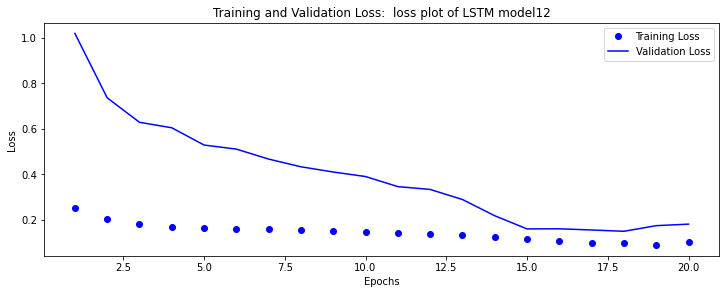

In [21]:
LSTM_model12 = models.Sequential()
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model12.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model12.add(layers.LSTM(50))


LSTM_model12.add(layers.Dense(1))

LSTM_model12.compile(optimizer=RMSprop(), loss='mse')
LSTM_model12_history = LSTM_model12.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model12_history, "loss plot of LSTM model12")

Epoch 1/20
13/13 [==============================] - 18s 722ms/step - loss: 0.4340 - val_loss: 1.4158
Epoch 2/20
13/13 [==============================] - 10s 813ms/step - loss: 0.2834 - val_loss: 1.0514
Epoch 3/20
13/13 [==============================] - 9s 667ms/step - loss: 0.2403 - val_loss: 0.9587
Epoch 4/20
13/13 [==============================] - 9s 667ms/step - loss: 0.2142 - val_loss: 0.8453
Epoch 5/20
13/13 [==============================] - 9s 697ms/step - loss: 0.2048 - val_loss: 0.7693
Epoch 6/20
13/13 [==============================] - 10s 762ms/step - loss: 0.1914 - val_loss: 0.6596
Epoch 7/20
13/13 [==============================] - 8s 593ms/step - loss: 0.1846 - val_loss: 0.5629
Epoch 8/20
13/13 [==============================] - 9s 709ms/step - loss: 0.1651 - val_loss: 0.4606
Epoch 9/20
13/13 [==============================] - 10s 778ms/step - loss: 0.1554 - val_loss: 0.3180
Epoch 10/20
13/13 [==============================] - 11s 909ms/step - loss: 0.1429 - val_loss: 0

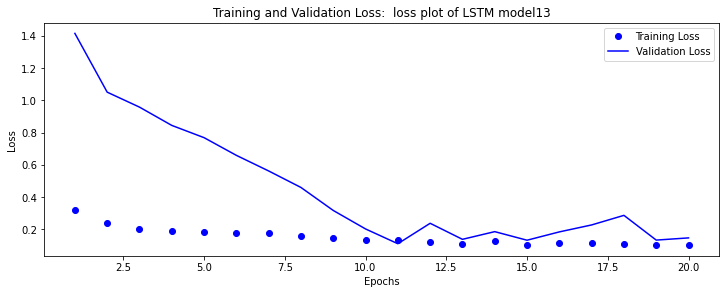

In [22]:
LSTM_model13 = models.Sequential()
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
LSTM_model13.add(layers.LSTM(50))


LSTM_model13.add(layers.Dense(1))

LSTM_model13.compile(optimizer=RMSprop(), loss='mse')
LSTM_model13_history = LSTM_model13.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model13_history, "loss plot of LSTM model13")

Epoch 1/20
13/13 [==============================] - 7s 326ms/step - loss: 0.3473 - val_loss: 0.4380
Epoch 2/20
13/13 [==============================] - 4s 275ms/step - loss: 0.1716 - val_loss: 0.3449
Epoch 3/20
13/13 [==============================] - 3s 268ms/step - loss: 0.1675 - val_loss: 0.2935
Epoch 4/20
13/13 [==============================] - 4s 342ms/step - loss: 0.1607 - val_loss: 0.2596
Epoch 5/20
13/13 [==============================] - 3s 272ms/step - loss: 0.1547 - val_loss: 0.2357
Epoch 6/20
13/13 [==============================] - 3s 267ms/step - loss: 0.1500 - val_loss: 0.2181
Epoch 7/20
13/13 [==============================] - 4s 275ms/step - loss: 0.1460 - val_loss: 0.2043
Epoch 8/20
13/13 [==============================] - 3s 268ms/step - loss: 0.1423 - val_loss: 0.1933
Epoch 9/20
13/13 [==============================] - 4s 279ms/step - loss: 0.1381 - val_loss: 0.1810
Epoch 10/20
13/13 [==============================] - 3s 265ms/step - loss: 0.1322 - val_loss: 0.1495

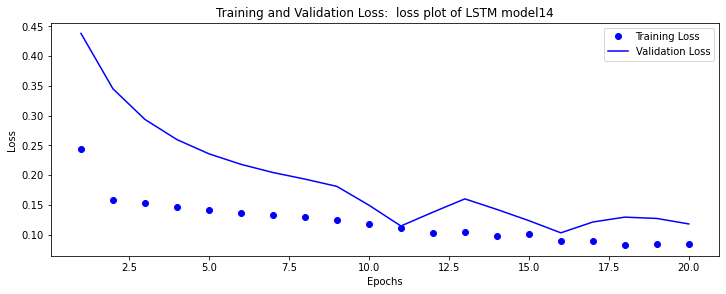

In [23]:
LSTM_model14 = models.Sequential()
LSTM_model14.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model14.add(layers.LSTM(32))


LSTM_model14.add(layers.Dense(1))

LSTM_model14.compile(optimizer=RMSprop(), loss='mse')
LSTM_model14_history = LSTM_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model14_history, "loss plot of LSTM model14")

Epoch 1/40
13/13 [==============================] - 6s 251ms/step - loss: 0.6588 - val_loss: 0.1238
Epoch 2/40
13/13 [==============================] - 2s 193ms/step - loss: 0.2687 - val_loss: 0.1885
Epoch 3/40
13/13 [==============================] - 3s 202ms/step - loss: 0.1846 - val_loss: 0.2503
Epoch 4/40
13/13 [==============================] - 2s 186ms/step - loss: 0.1640 - val_loss: 0.2606
Epoch 5/40
13/13 [==============================] - 3s 201ms/step - loss: 0.1556 - val_loss: 0.2549
Epoch 6/40
13/13 [==============================] - 2s 190ms/step - loss: 0.1504 - val_loss: 0.2461
Epoch 7/40
13/13 [==============================] - 2s 188ms/step - loss: 0.1463 - val_loss: 0.2373
Epoch 8/40
13/13 [==============================] - 3s 200ms/step - loss: 0.1427 - val_loss: 0.2294
Epoch 9/40
13/13 [==============================] - 3s 215ms/step - loss: 0.1396 - val_loss: 0.2223
Epoch 10/40
13/13 [==============================] - 2s 193ms/step - loss: 0.1366 - val_loss: 0.2159

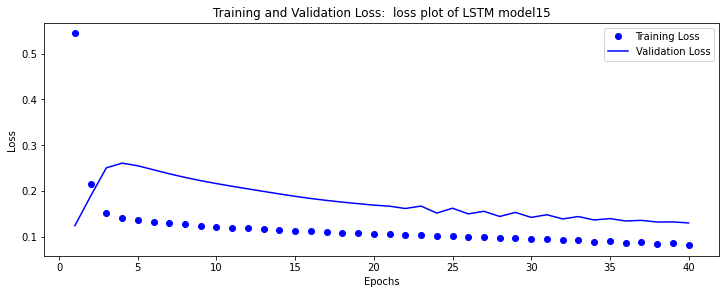

In [24]:
LSTM_model15 = models.Sequential()
LSTM_model15.add(layers.LSTM(16, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model15.add(layers.LSTM(16))


LSTM_model15.add(layers.Dense(1))

LSTM_model15.compile(optimizer=RMSprop(), loss='mse')
LSTM_model15_history = LSTM_model15.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(LSTM_model15_history, "loss plot of LSTM model15")

Epoch 1/20
13/13 [==============================] - 8s 431ms/step - loss: 0.4133 - val_loss: 0.9496
Epoch 2/20
13/13 [==============================] - 4s 326ms/step - loss: 0.2259 - val_loss: 0.5977
Epoch 3/20
13/13 [==============================] - 4s 319ms/step - loss: 0.1792 - val_loss: 0.4775
Epoch 4/20
13/13 [==============================] - 4s 343ms/step - loss: 0.1683 - val_loss: 0.3988
Epoch 5/20
13/13 [==============================] - 5s 397ms/step - loss: 0.1597 - val_loss: 0.3459
Epoch 6/20
13/13 [==============================] - 5s 363ms/step - loss: 0.1526 - val_loss: 0.3060
Epoch 7/20
13/13 [==============================] - 5s 366ms/step - loss: 0.1461 - val_loss: 0.2722
Epoch 8/20
13/13 [==============================] - 5s 403ms/step - loss: 0.1397 - val_loss: 0.2427
Epoch 9/20
13/13 [==============================] - 5s 409ms/step - loss: 0.1321 - val_loss: 0.2066
Epoch 10/20
13/13 [==============================] - 5s 405ms/step - loss: 0.1239 - val_loss: 0.1757

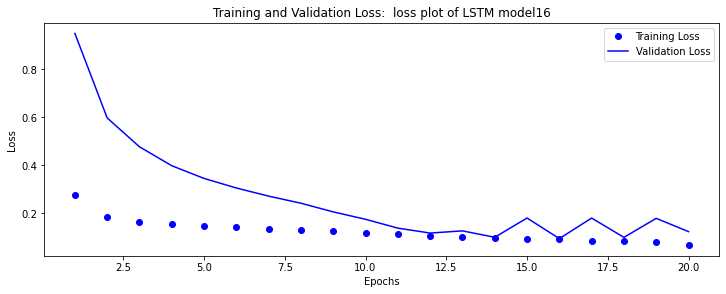

In [25]:
LSTM_model16 = models.Sequential()
LSTM_model16.add(layers.LSTM(64, return_sequences=True, input_shape=(shape_1, shape_2)))

LSTM_model16.add(layers.LSTM(64))


LSTM_model16.add(layers.Dense(1))

LSTM_model16.compile(optimizer=RMSprop(), loss='mse')
LSTM_model16_history = LSTM_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(LSTM_model16_history, "loss plot of LSTM model16")

Epoch 1/30
13/13 [==============================] - 13s 549ms/step - loss: 0.3312 - val_loss: 1.0830
Epoch 2/30
13/13 [==============================] - 6s 446ms/step - loss: 0.2973 - val_loss: 0.6446
Epoch 3/30
13/13 [==============================] - 5s 415ms/step - loss: 0.2325 - val_loss: 0.5902
Epoch 4/30
13/13 [==============================] - 5s 389ms/step - loss: 0.2189 - val_loss: 0.5497
Epoch 5/30
13/13 [==============================] - 5s 421ms/step - loss: 0.2101 - val_loss: 0.5150
Epoch 6/30
13/13 [==============================] - 6s 469ms/step - loss: 0.2032 - val_loss: 0.4847
Epoch 7/30
13/13 [==============================] - 6s 455ms/step - loss: 0.1968 - val_loss: 0.4578
Epoch 8/30
13/13 [==============================] - 6s 485ms/step - loss: 0.1907 - val_loss: 0.4338
Epoch 9/30
13/13 [==============================] - 5s 385ms/step - loss: 0.1847 - val_loss: 0.4112
Epoch 10/30
13/13 [==============================] - 5s 406ms/step - loss: 0.1785 - val_loss: 0.388

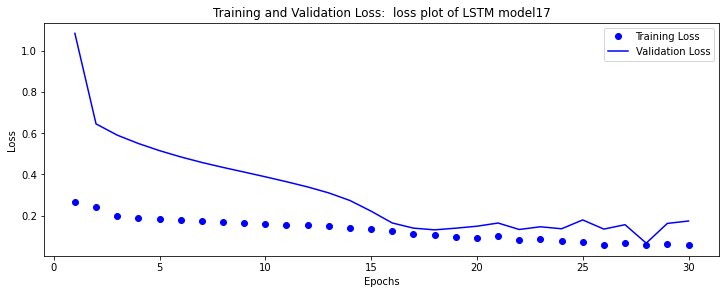

In [26]:
LSTM_model17 = models.Sequential()
LSTM_model17.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32, return_sequences=True))
LSTM_model17.add(layers.LSTM(32))


LSTM_model17.add(layers.Dense(1))

LSTM_model17.compile(optimizer=RMSprop(), loss='mse')
LSTM_model17_history = LSTM_model17.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model17_history, "loss plot of LSTM model17")

Epoch 1/30
13/13 [==============================] - 11s 425ms/step - loss: 0.4160 - val_loss: 0.7553
Epoch 2/30
13/13 [==============================] - 4s 330ms/step - loss: 0.2567 - val_loss: 0.5104
Epoch 3/30
13/13 [==============================] - 5s 359ms/step - loss: 0.2076 - val_loss: 0.4548
Epoch 4/30
13/13 [==============================] - 4s 318ms/step - loss: 0.1937 - val_loss: 0.4187
Epoch 5/30
13/13 [==============================] - 4s 321ms/step - loss: 0.1846 - val_loss: 0.3895
Epoch 6/30
13/13 [==============================] - 4s 317ms/step - loss: 0.1766 - val_loss: 0.3654
Epoch 7/30
13/13 [==============================] - 4s 322ms/step - loss: 0.1690 - val_loss: 0.3443
Epoch 8/30
13/13 [==============================] - 4s 320ms/step - loss: 0.1618 - val_loss: 0.3254
Epoch 9/30
13/13 [==============================] - 4s 317ms/step - loss: 0.1550 - val_loss: 0.3080
Epoch 10/30
13/13 [==============================] - 4s 314ms/step - loss: 0.1487 - val_loss: 0.291

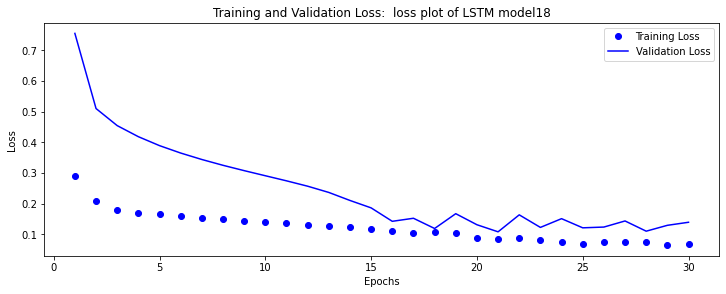

In [27]:
LSTM_model18 = models.Sequential()
LSTM_model18.add(layers.LSTM(32, return_sequences=True, input_shape=(shape_1, shape_2)))
LSTM_model18.add(layers.LSTM(32, return_sequences=True))
LSTM_model18.add(layers.LSTM(32))


LSTM_model18.add(layers.Dense(1))

LSTM_model18.compile(optimizer=RMSprop(), loss='mse')
LSTM_model18_history = LSTM_model18.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(LSTM_model18_history, "loss plot of LSTM model18")